### Loading in the data

In [1]:
# Load in the relevant libraries 
# install.packages('readr', repos='http://cran.us.r-project.org')
library(dplyr)
library(lubridate)
library(stringr)
library(sf)
library(ggplot2)
library(ggmap)
library(hexbin)
library(tidytext)
library(geosphere)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date

Linking to GEOS 3.6.1, GDAL 2.2.3, PROJ 4.9.3
Google's Terms of Service: https://cloud.google.com/maps-platform/terms/.
Please cite ggmap if you use it! See citation("ggmap") for details.
Warning message:
"package 'tidytext' was built under R version 3.6.3"

In [2]:
# Define the colour palette for visualizations
black <- '#080F0F'
blue <- '#A4BAB7'
yellow <- '#EFF2C0'
brown <- '#BEA57D'
red <- '#A52422'

In [12]:
# Which case study are we focusing on?
# tac, nep, pap, car
case <- 'hed'

# Read in the case details file and subset appropriately 
cases <- read.csv('C:\\Users\\hanna\\Desktop\\Dissertation\\3_Analyzing\\Data\\case_studies.csv', stringsAsFactors=FALSE)

sel <- cases%>%filter(Location == case)


# Get the case-specific variables 
start <- sel[[7]]
end <- sel[[8]]
north <- sel[[3]]
south <- sel[[4]]
east <- sel[[5]]
west <- sel[[6]]

print(start)
print(end)

[1] "2009-12-31"
[1] "2010-12-31"


In [13]:
# Read in the appropriate data
path_node <- paste0('C:\\Users\\hanna\\Desktop\\Dissertation\\3_Analyzing\\Data\\', case, '-nodes.csv')
path_way <- paste0('C:\\Users\\hanna\\Desktop\\Dissertation\\3_Analyzing\\Data\\', case, '-ways.csv')

data_node <- read.csv(path_node, stringsAsFactors=FALSE)
data_way <- read.csv(path_way, stringsAsFactors=FALSE)

# Join the nodes and ways data
data <- rbind(data_node, data_way)

print(dim(data))

[1] 31409    13


In [14]:
head(data,5)

OSH_ID,OSH_TYP,OSH_BB_a,OSH_BB_b,OSH_BB_c,OSH_BB_d,OSM_UID,OSM_CHG,OSM_VER,OSM_TME,OSM_KYS,OSM_VIS,OSM_TGS
602328281,NODE,(8.7218634,49.39192,8.721863,49.3919286),202726,10422648,2,2012-01-17T21:48:22,amenity@backrest@seats@material@colour,true,amenity=bench@backrest=yes@seats=3@material=wood@colour=brown
602328281,NODE,(8.7218634,49.39192,8.721863,49.3919286),202726,3504190,1,2009-12-31T21:43:13,amenity@backrest@seats@material@colour,true,amenity=bench@backrest=yes@seats=3@material=wood@colour=brown
602328287,NODE,(8.7218839,49.39200,8.721958,49.3920532),367722,51695524,4,2017-09-03T15:27:06,source@tourism@fireplace,true,source=HiRes aerial imagery@tourism=picnic_site@fireplace=no
602328287,NODE,(8.7218839,49.39200,8.721958,49.3920532),202726,10422648,3,2012-01-17T21:48:23,source@tourism@fireplace,true,source=HiRes aerial imagery@tourism=picnic_site@fireplace=no
602328287,NODE,(8.7218839,49.39200,8.721958,49.3920532),202726,5428857,2,2010-08-07T23:39:47,tourism@fireplace,true,tourism=picnic_site@fireplace=no


### Data cleaning

In [15]:
# Clean and transform some columns 
data <- data %>% 
    mutate(OSM_TME = as.Date(ymd_hms(OSM_TME)))%>% # Format the time more simply
    mutate(OSH_BB_a = as.numeric(substring(OSH_BB_a, 2)))%>% # Clean up the coordinates columns
    mutate(OSH_BB_b = as.numeric(OSH_BB_b))%>%
    mutate(OSH_BB_c = as.numeric(OSH_BB_c))%>%
    mutate(OSH_BB_d = as.numeric(substring(OSH_BB_d,1,nchar(as.character(OSH_BB_d))-1)))%>%
    filter(OSM_TME >= as.Date(start))

In [16]:
# What does the data look like now?
head(data,1)

OSH_ID,OSH_TYP,OSH_BB_a,OSH_BB_b,OSH_BB_c,OSH_BB_d,OSM_UID,OSM_CHG,OSM_VER,OSM_TME,OSM_KYS,OSM_VIS,OSM_TGS
602328281,NODE,8.721863,49.39192,8.721863,49.39193,202726,10422648,2,2012-01-17,amenity@backrest@seats@material@colour,true,amenity=bench@backrest=yes@seats=3@material=wood@colour=brown


### Analyzing the dynamics/characteristics of data production

In [18]:
# Filtering to answer some basic questions

# --- How many creations over the mapping activation?
tot_create <- nrow(data %>% filter(OSM_VER == 1))

# --- How many unique contributors over the mapping activation?
tot_contrib <- nrow(data %>% filter(OSM_VER == 1) %>% distinct(OSM_UID))

# --- How many unique changesets over the mapping activation?
tot_change <- nrow(data %>% filter(OSM_VER == 1) %>% distinct(OSM_CHG))

# --- How many contributions have been updated following the mapping activation? 
tot_mod <- nrow(data %>% 
    filter(OSM_TME > end) %>% # Only get the edits made after the end of the activation
    group_by(OSH_ID)%>% # Group by OSH ID
    summarise(MAX_VER = max(OSM_VER))) # Get the maximum version of each OSHEntity

# -- What percent of nodes and ways created during the activation have since been modified?
per_mod <- tot_mod/tot_create*100 # Percent of contributions that were modified

# --- How many days did it take for half of all contributions to be made?
arranged <- data %>% arrange(OSM_TME)%>% filter(OSM_VER == 1) # Arrange by date and make sure only new contributions
burst <- as.numeric(as.period(as.Date(start)%--%as.Date(arranged['OSM_TME'][tot_create/2,])), 'day')  

# --- Is this activation an event or a mission?
style <- ''
if(burst<=60){style='event'}
if(burst>60){style='mission'}

# --- What is the total duration of the activation?
dur <- as.numeric(as.period(as.Date(start)%--%as.Date(end)), 'day')  

# --- What is the size of this study area?
poly <- data.frame( # Create as dataframe 
  lon = c(east, west, west, east),
  lat = c(north, north, south, south)
)
area <- areaPolygon(poly)/1000000 # Calculate the area in sq m

# --- Print summary
print(paste('Created nodes and ways:', tot_create))
print(paste('Unique contributors:', tot_contrib))
print(paste('Total changesets:', tot_change))
print(paste('Total modified after activation:',tot_mod))
print(paste('Percent maintenance:', round(per_mod,2)))
print(paste('Days until 50% of contributions made:', burst))
print(paste('This activation is a(n):', style))
print(paste('Total duration of activation (days):', round(dur)))
print(paste('Size of study area (km^2):', round(area)))

[1] "Created nodes and ways: 9070"
[1] "Unique contributors: 142"
[1] "Total changesets: 768"
[1] "Total modified after activation: 8100"
[1] "Percent maintenance: 89.31"
[1] "Days until 50% of contributions made: 339.8125"
[1] "This activation is a(n): mission"
[1] "Total duration of activation (days): 365"
[1] "Size of study area (km^2): 192"


In [19]:
# Write the results to a dataframe
output_data <- data.frame(
    'Created'= tot_create,
    'Contrib'= tot_contrib,
    'Changesets'=tot_change,
    'Modified_after'=tot_mod,
    'Per_maint'=per_mod,
    'Burst'=burst,
    'Style'=style,
    'Duration'=dur,
    'Area'=area
)

### Parsing the tags

In [20]:
# What tags are associated with elements that are updated more frequently? 
# What tags are associated with the elements that were contributed?
tags <- data %>% filter(OSM_VER == 1)%>%select(OSM_TGS)

In [21]:
# Sample of what the tags look like
tags[1:10,]

[1] "amenity=bench@backrest=yes@seats=3@material=wood@colour=brown" 
 [2] "tourism=picnic_site@fireplace=no"                              
 [3] "amenity=bench@backrest=yes@seats=4@material=wood@colour=brown" 
 [4] "amenity=bench@backrest=yes@seats=3@material=metal@colour=brown"
 [5] "bicycle=yes@barrier=lift_gate@foot=yes"                        
 [6] "bicycle=yes@barrier=lift_gate@foot=yes"                        
 [7] "bicycle=yes@barrier=bollard@foot=yes"                          
 [8] "amenity=fountain"                                              
 [9] "highway=crossing@crossing=uncontrolled"                        
[10] "amenity=bench@backrest=yes@seats=3@material=wood@colour=brown"

In [22]:
# Understanding the data sources 

# --- Get everything after the source tag and before any other tags 
# This also takes a while....
tags_list <- c()
for(i in 1:nrow(tags)){
    if(str_detect(tags[i,], 'source')){
        a <- str_match(tags[i,], "source=s*(.*?)$")[,2]
        b <- ((strsplit(a, '@')[[1]][1]))
        tags_list <- c(tags_list, b)

    }
}

# Create in tibble format
text <- tibble(tags_list)

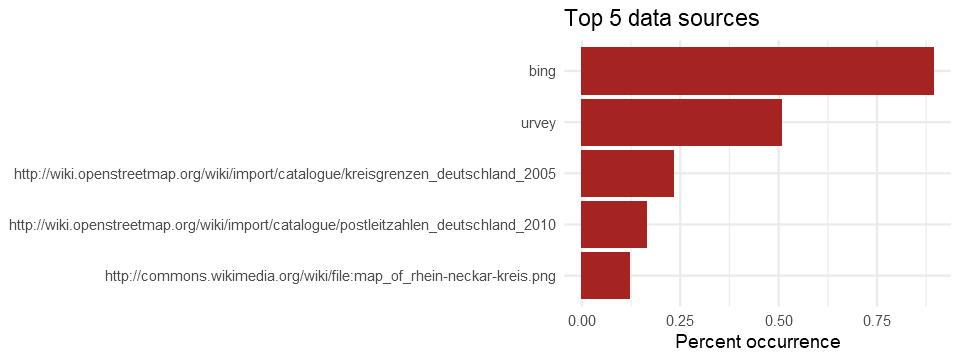

In [23]:
# Plot formatting
options(repr.plot.width=8, repr.plot.height=3)

# --- Create a plot to show the most frequently occurring data sources
source_graph <- text %>%
    mutate(tags_list = tolower(tags_list))%>%
    count(tags_list, sort = TRUE)%>%
    mutate(word_per = n/tot_create*100)%>%
    mutate(word = reorder(tags_list, word_per))%>%
    top_n(5, word_per)%>%
    ggplot(aes(word, word_per)) +
    geom_col(fill=red) +
    xlab(NULL) +
    coord_flip()+
    labs(title='Top 5 data sources', y='Percent occurrence')+
    theme_minimal()

source_graph

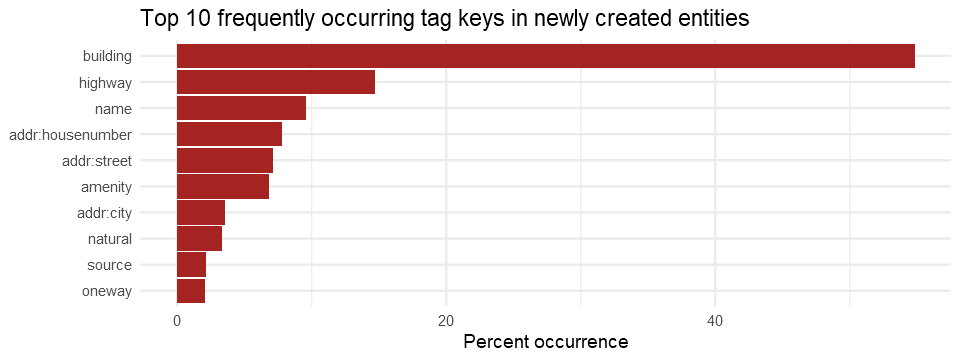

In [24]:
text_df <- data %>% filter(OSM_VER == 1)
text_df <- tibble(text_df$OSM_KYS)

keys_graph <- text_df %>%
    unnest_tokens(word, `text_df$OSM_KYS`)%>%
    count(word, sort = TRUE)%>%
    mutate(percent = n/tot_create*100)%>%
    mutate(word = reorder(word, percent))%>%
    top_n(10, percent)%>%
    ggplot(aes(word, percent)) +
    geom_col(fill=red) +
    xlab(NULL) +
    coord_flip()+
    labs(title='Top 10 frequently occurring tag keys in newly created entities', y='Percent occurrence')+
    theme_minimal()

keys_graph

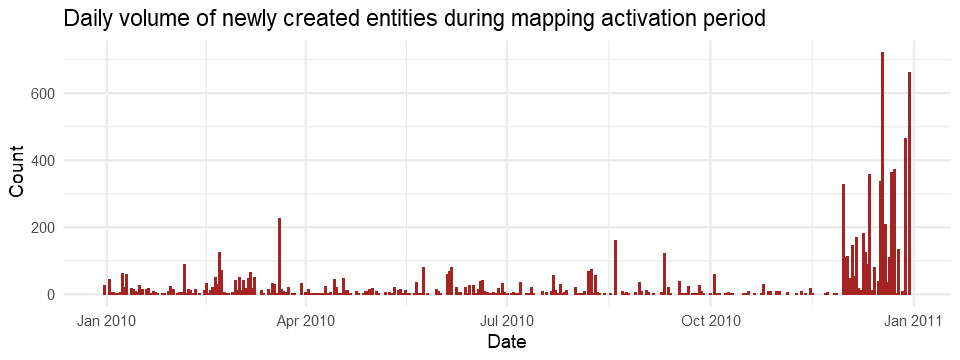

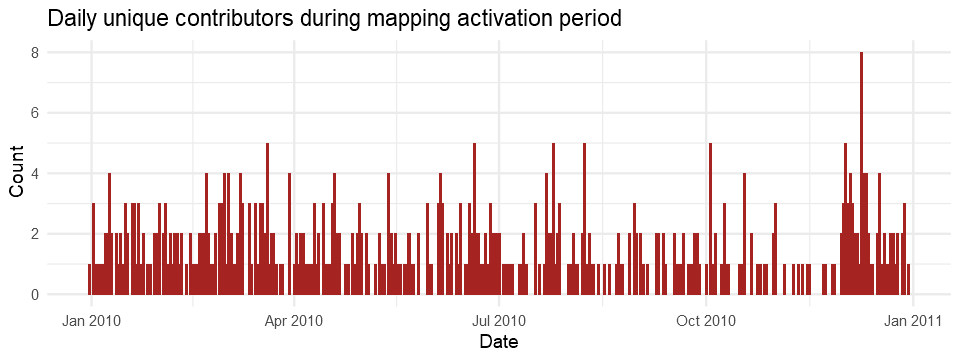

In [25]:
# Create plots of the time series of contributions 

# Plot formatting
options(repr.plot.width=8, repr.plot.height=3)

# --- Show me the daily contributions over the activation period
daily_adds <- data %>%
    filter(OSM_VER == 1)%>%
    group_by(Date = OSM_TME)%>% 
    summarise(Count = n())

edits <- ggplot(daily_adds, aes(x=Date, y=Count))+
    geom_bar(stat='identity', fill=red)+
    theme_minimal()+
    labs(title='Daily volume of newly created entities during mapping activation period')

edits
# --- Show me the daily contributors over the activation period? 
daily_users <- data %>%
    filter(OSM_VER == 1)%>%
    group_by(Date = OSM_TME)%>% 
    summarize(Unique = n_distinct(OSM_UID))

ppl <- ggplot(daily_users, aes(x=Date, y=Unique))+
    geom_bar(stat='identity', fill=red)+
    theme_minimal()+
    labs(title='Daily unique contributors during mapping activation period', y='Count')

ppl

In [26]:
daily_users$Day <- seq.int(nrow(daily_users))
daily_adds$Day <- seq.int(nrow(daily_adds))

### Maintenance frequency

In [ ]:
#head(data)
test <- data[data$OSH_ID == 2526021349, c("OSM_VER","OSM_TME")]
test

In [ ]:
mean(diff(test$OSM_TME))

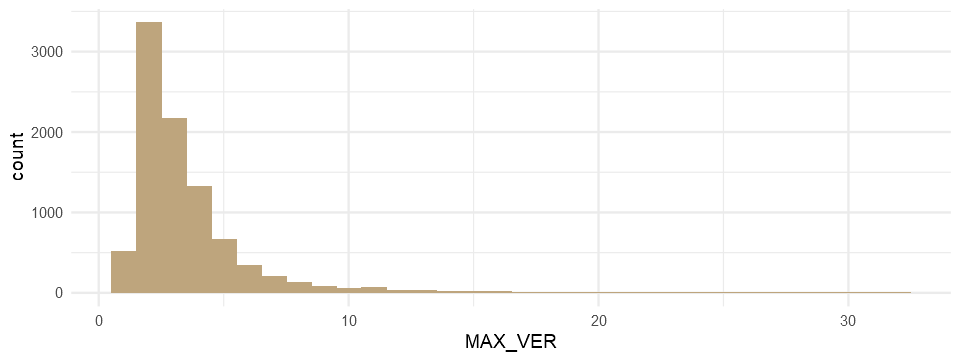

In [27]:
# The maximum version of each OSH entity

# Plot formatting
options(repr.plot.width=8, repr.plot.height=3)

max <- data %>% 
    group_by(OSH_ID)%>% # Group by OSH ID
    summarise(MAX_VER = max(OSM_VER))

ggplot(max, aes(x=MAX_VER))+
    geom_histogram(binwidth=1, fill=brown)+
    theme_minimal()

In [28]:
# Get the maintenance ratio after 1, 2, 3 years
years <- c(1,2,3,4,5)
maint_time <- c()
for(year in years){
    # Get the edits made from 
    
    st <- as.Date(end)
    nd <- as.Date(end) %m+% years(year)
    
    sel <- data %>% filter(OSM_TME>st & OSM_TME<nd)%>% # Only get the edits made within time of interest
    group_by(OSH_ID)%>% # Group by OSH ID
    summarise(MAX_VER = max(OSM_VER)) # Get the max version
    per <- nrow(sel)/tot_create*100 # Get the percent maintenance for that time period
    maint_time <- c(maint_time, per)

}

print(maint_time)

maint_time <- data.frame('Years'=c(years), 'Maint_per'=c(maint_time))

print(maint_time)

[1] 29.80154 44.03528 57.12238 78.41235 83.50606
  Years Maint_per
1     1  29.80154
2     2  44.03528
3     3  57.12238
4     4  78.41235
5     5  83.50606


### Spatial Analysis

In [29]:
# Work on the spatial dimension 

# --- Function to get either the lat or the lon coord from the bounding box
getCoord <- function(north, south, east, west, type, coord){
    # If it's a node then just return one of the existing coords 
    if(type=='NODE'){
        if(coord=='lon'){
            return(east)
        }
        if(coord=='lat'){
            return(north)
        }
    }
    # If it's a way then we need to calculate the centroid of the bbox
    if(type=='WAY'){
      box <- list(matrix(c(
                north, east, 
                north, west, 
                south, west, 
                south, east, 
                north, east), ncol=2, byrow=TRUE))
        point <- st_coordinates(st_centroid(st_polygon(box)))

        if(coord=='lon'){
            return(point[2])
        }
        if(coord=='lat'){
            return(point[1])
        }       
    } 
}

# --- Create the new column in the dataframe using the function from above
# PSA this is SLOWWW :( 
wcoords <- data %>% 
    rowwise() %>%
    mutate(Lat = getCoord(OSH_BB_a, OSH_BB_c, OSH_BB_b, OSH_BB_d, OSH_TYP, 'lat'))%>%
    mutate(Lon = getCoord(OSH_BB_a, OSH_BB_c, OSH_BB_b, OSH_BB_d, OSH_TYP, 'lon'))

In [30]:
# Create sf object with the dataframe

# --- Define the CRS
projcrs <- "+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0"

# --- Create sf object 
data_geom <- st_as_sf(x = wcoords,                         
           coords = c("Lon", "Lat"),
           crs = projcrs)

# --- Remove the unneeded columns 
data_geom <- data_geom %>% select(c(1,2,7,8,9,10,11,12))

In [31]:
# Read sf object of the basemap area
shp <- readRDS(paste0(case, '.rds'))

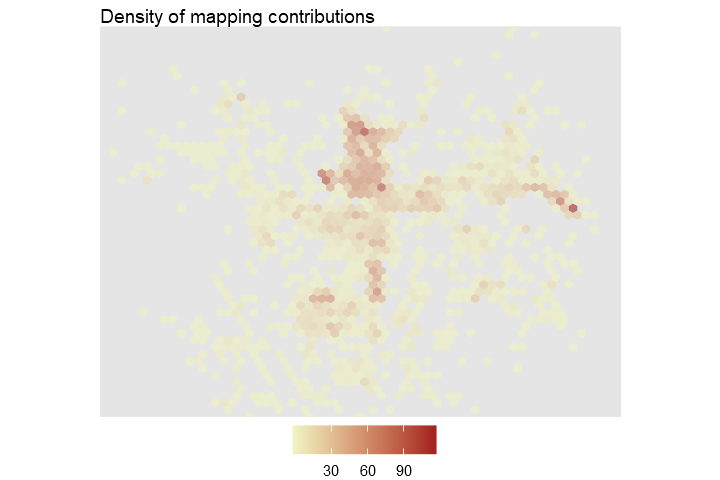

In [32]:
# Where were these new contributions located? 

# Plot formatting
options(repr.plot.width=6, repr.plot.height=4)

# --- Filter to get only the new contribtions, not later revisions
data_geom_sel <- data_geom %>% filter(OSM_VER == 1)
wcoords_sel <- wcoords %>% filter(OSM_VER == 1)

# --- Create the map of edits - hexbin map to show density of edits over space
map <- ggplot(data=shp) +
    geom_sf() +
    coord_sf(xlim = c(west, east), ylim = c(north, south), expand = FALSE)+
    theme_void()+
    geom_hex(data=wcoords_sel, aes(x=Lat, y=Lon), bins=80, alpha = 0.6)+
    scale_fill_gradient(low = yellow,
          high = red)+
    theme(legend.position="bottom",
         legend.title = element_blank())+
    labs(subtitle='Density of mapping contributions')

map

### Write results to directory

In [33]:
# --- Directory to write results to 
saveDir <- paste0('C:\\Users\\hanna\\Desktop\\Dissertation\\3_Analyzing\\Results\\', case)
dir.create(file.path(saveDir), showWarnings=FALSE)

# --- Save graphs
# ggsave('hmap_contrib.png', map, path=saveDir, width=4, height=4, units='in', dpi=300)
ggsave('daily_contrib.png', edits, path=saveDir, width=8, height=3, units='in', dpi=300)
ggsave('daily_users.png', ppl, path=saveDir, width=8, height=3, units='in', dpi=300)
ggsave('source_graph.png', source_graph, path=saveDir, width=8, height=3, units='in', dpi=300)
ggsave('keys_graph.png', keys_graph, path=saveDir, width=8, height=3, units='in', dpi=300)

# --- Write numerical results
write.csv(max, paste0(saveDir, '\\max_ver.csv'))
write.csv(output_data, paste0(saveDir, '\\output_results.csv'))
write.csv(daily_adds, paste0(saveDir, '\\daily_adds.csv'))
write.csv(daily_users, paste0(saveDir, '\\daily_users.csv'))
write.csv(maint_time, paste0(saveDir, '\\maint_time.csv'))